## Imports 

In [34]:
import numpy as np 
from numpy import linalg as LA
from scipy.linalg import norm
import matplotlib.pyplot as plt
import time
from numpy import *
import pandas as pd
from scipy.sparse import rand
import scipy.sparse as sparse

import glob
from PIL import Image
from IPython.display import Image as PyImage
from os import remove

## Functions

In [35]:
def arnoldi_iteration(A, b, k, tol):
    
    """
    Computes a basis of the (n + 1)-Krylov subspace of A: the space
    spanned by {b, Ab, ..., A^n b}.

    Arguments
      A: m x m array
      b: initial vector (length m)
      n: dimension of Krylov subspace, must be >= 1

    Returns
      Q: m x (n + 1) array, the columns are an orthonormal basis of the
        Krylov subspace.
      h: (n + 1) x n array, A on basis Q. It is upper Hessenberg.
    """

    # Inizialize matrix
    Q = np.zeros((b.shape[0], k+1))
    H = np.zeros((k+1, k))
    
    # Normalize input vector and use for Krylov vector
    Q[:, 0] = (b /np.linalg.norm(b, 2)).T 

    # List of eig find 
    eig_list = []
    
    for j in range(k-1):
        
        # Generate a new candidate vector
        Q[:, j+1] = A @ Q[:, j]
        
        # Subtract the projections on previous vectors
        for i in range(j):
            H[i,j] = Q[:, i].T @ Q[:, j+1]
            Q[:, j+1] = Q[:, j+1] - H[i,j] * Q[:, i]
        
        H[j+1,j] = np.linalg.norm(Q[:, j+1], 2)

        # Append max eigenvalue
        eig_list.append(sorted(sparse.linalg.eigs(H[:-1, :])[0], reverse=True))
        
        if abs(H[j+1, j]) < tol:
            print("Convergenza !!")
            return Q[:, :j+1], H[:j+1, :j+1], eig_list
        
        Q[:, j+1] = Q[:, j+1]/H[j+1, j]
    
    return Q, H[:-1,:], eig_list

In [36]:
# Calcolate relative error
def relative_error(xnew, xold):
    return abs((xnew-xold)/xnew)*100

In [37]:
def power_method(A, b, iteration:100, eps = 1e-12):
    """
        Ideally choose a random vector
        To decrease the chance that our vector
        Is orthogonal to the eigenvector
    """
    
    # Create df result
    result = pd.DataFrame(columns=['eigenvalue', 'error'])
    
    # Inizialize eig
    eigenvalue = 0 
    
    # Inizialize old eig
    oldeigenvalue = 0 
    
    for i in range(iteration):
        # Calculate the matrix-by-vector product Ab
        b = A @ b 
        
        # Calcolate norm of eigenvalue
        eigenvalue = np.linalg.norm(b)
        
        # Re normalize the vector
        b = b / eigenvalue 
        
        # Calcolate relative error between old an new eigh
        error = relative_error(eigenvalue, oldeigenvalue)
        
        # Insert eigen and error to df
        result.loc[i] = [eigenvalue, error] 
        
        # Check accuracy
        if error < eps: 
            break
        
        # Swap
        oldeigenvalue = eigenvalue 
    
    return result

## Tests

Generazione matrice sparsa non clusterizzata

In [38]:
dim = 3000
A = sparse.random(dim, dim, density=1.)
b = np.random.random((dim,1))

Performe Arnoldi Iteration

In [39]:
Q, h, eig_list = arnoldi_iteration(A, b, 100, tol = 1e-12)

Find eigenvalue

In [43]:
u, v = sparse.linalg.eigs(A)
u_h, v_h = sparse.linalg.eigs(h)

u = sorted(u, reverse=True)
u_h = sorted(u_h, reverse=True)

print(u)
print()
print(u_h)

TypeError: 'coo_matrix' object is not subscriptable

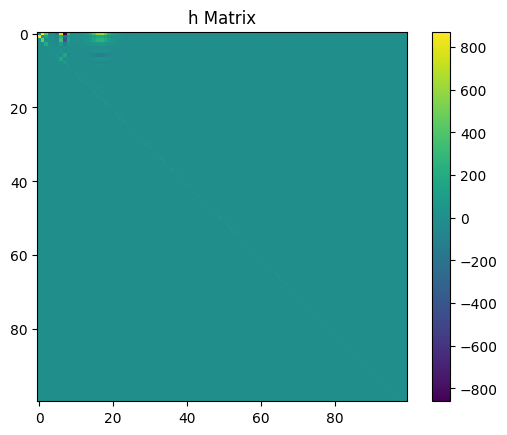

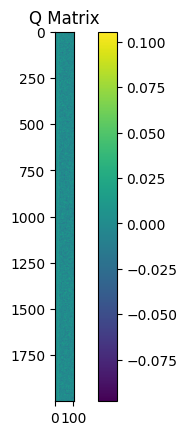

In [24]:
plt.imshow(h)
plt.colorbar()
plt.title("h Matrix")
plt.show()

plt.imshow(Q)
plt.colorbar()
plt.title("Q Matrix")
plt.show()

In [29]:
from natsort import natsorted as ns

def show_images(eig_list, u, column=5, fig_size=(5, 5)):
  min_e = np.min(eig_list)-10
  max_e = np.max(eig_list)+10
  for i in range(len(eig_list)):
    plt.ylim([min_e, max_e])
    plt.title(f"Iter: {i}")
    plt.plot(eig_list[i], 'o', color='r')
    plt.plot(u, 'o', color='g')
  
    plt.savefig(f"./gif_dir/{i}.jpg")
    plt.close()
    



def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  step = 500
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.title('step: {}'.format(int(i)))
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in ns(glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg"))]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save( "eigen_approx.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)
  
  [remove(f) for f in a]

In [30]:
%%capture
show_images(eig_list, u)
make_gif("./", 500)

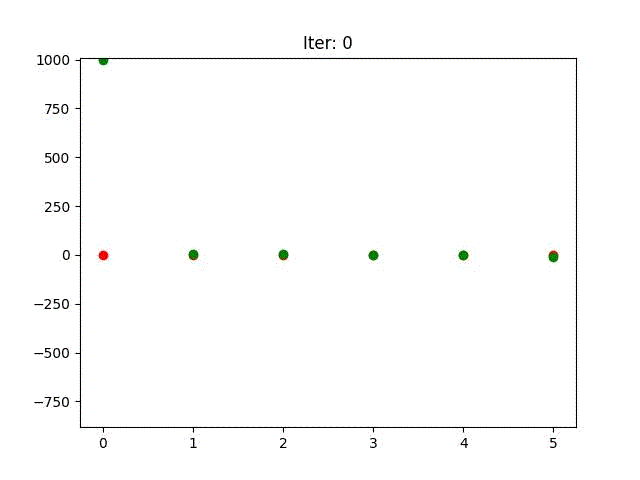

In [31]:
PyImage(filename='eigen_approx.gif')

Generazione matrice clasterizzata

In [32]:
A = sparse.random(dim, dim, 1., dtype=np.float64)*0.01 + sparse.eye(dim,)*4
Q, h, eigh_list_cluster = arnoldi_iteration(A, b, 100, tol=1e-12)

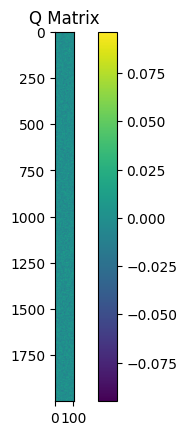

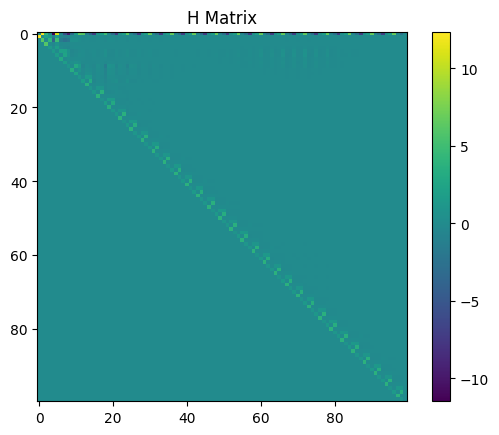

In [33]:
plt.imshow(Q)
plt.colorbar()
plt.title("Q Matrix")
plt.show()

plt.imshow(h)
plt.colorbar()
plt.title("H Matrix")
plt.show()


In [188]:
from natsort import natsorted as ns


def show_images(eig_list_cluster, u, column=5, fig_size=(5, 5)):
  min_e = np.min(eig_list_cluster)-10
  max_e = np.max(eig_list_cluster)+10
  for i in range(len(eig_list_cluster)):
    plt.ylim([min_e, max_e])
    plt.title(f"Iter: {i}")
    plt.plot(eig_list_cluster[i], 'o', color='r', label="Eighenvalue find on H")
    plt.plot(u, 'o', color='g', label="Eighenvalue find on A")

    plt.savefig(f"./gif_dir/{i}.jpg")
    plt.close()


def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  step = 500
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.title('step: {}'.format(int(i)))
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i))

  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in ns(
      glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg"))]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save("eigen_approx_cluster.gif", format="GIF",
                 append_images=frames, save_all=True, duration=duration, loop=0)

  [remove(f) for f in a]


In [190]:
%%capture
show_images(eigh_list_cluster, u)
make_gif("./", 500)


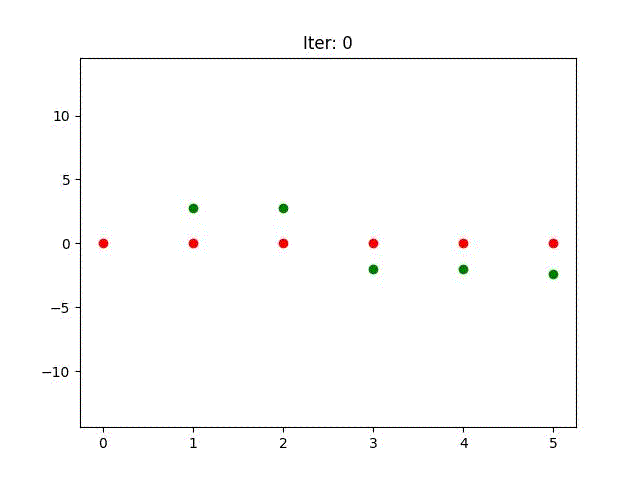

In [191]:
PyImage(filename='eigen_approx_cluster.gif')

Metodo Potenze

In [192]:
u, v = sparse.linalg.eigs(A)
u_h, v_h = sparse.linalg.eigs(h)

u = sorted(u, reverse=True)
u_h = sorted(u_h, reverse=True)

print(u)
print(u_h)


[(49.57525967260724+0j), (2.7463334278450375+1.3306559293854543j), (2.7463334278450375-1.3306559293854543j), (-1.9727303044684954+2.127328491217995j), (-1.9727303044684954-2.127328491217995j), (-2.3987742135701087-1.5798778398558548j)]
[(49.575259672607224+0j), (5.368015535009848+0j), (3.091874047977001+0j), (-8.833165656361128+0j), (-11.889900934595214+0j), (-37.65304625122914+0j)]


In [226]:
res = power_method(A, b, iteration=100, eps=1e-15)

print(res['error'])

0     1.000000e+02
1     3.678057e+02
2     6.075703e-02
3     1.398577e-03
4     9.778652e-05
5     3.086008e-06
6     2.735735e-07
7     1.847677e-08
8     7.665078e-11
9     6.839520e-11
10    1.834574e-12
11    1.003283e-13
12    0.000000e+00
Name: error, dtype: float64


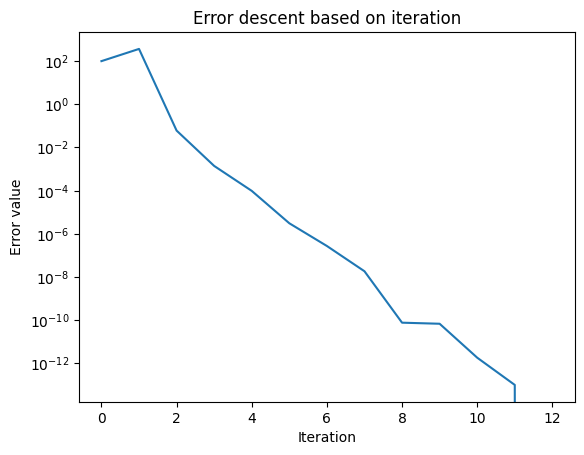

In [228]:

plt.title('Error descent based on iteration')
plt.xlabel('Iteration')
plt.ylabel('Error value')
plt.semilogy(res['error'])
plt.show()

In [206]:
s_power = res.iloc[-1]['eigenvalue']
s_a = np.max(u)
s_h = np.max(u_h)

In [207]:
print(s_power)
print(s_a)
print(s_h)

49.575259672607224
(49.57525967260724+0j)
(49.575259672607224+0j)


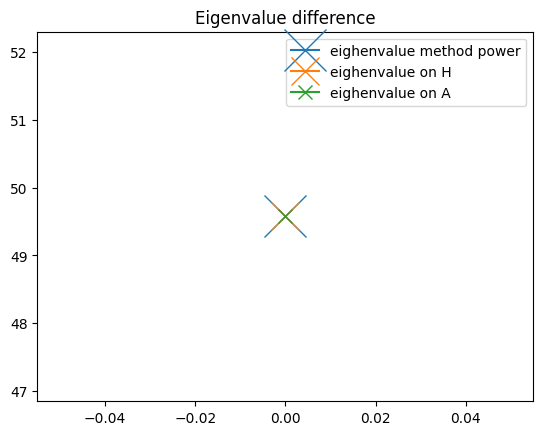

In [220]:

plt.title('Eigenvalue difference')
plt.plot(s_power, '-x', markersize=30, label="eighenvalue method power")
plt.plot(s_h, '-x', markersize=20, label="eighenvalue on H")
plt.plot(s_a, '-x', markersize=10, label="eighenvalue on A")
plt.legend(loc="upper right")
plt.show()
